***Image Enhancement AI***

**Rohan Sharma**

**Step 1: Mount Google Drive in Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step 2: Copy kaggle.json to the Kaggle Directory**

In [2]:
# Define the path to kaggle.json in Google Drive
kaggle_json_path = '/content/drive/My Drive/Kaggle_API/kaggle.json'

# Make the .kaggle directory and copy the kaggle.json file
!mkdir -p ~/.kaggle
!cp "{kaggle_json_path}" ~/.kaggle/

# Set permissions to ensure the API key is secure
!chmod 600 ~/.kaggle/kaggle.json

**Step 3: Install the Kaggle API**

In [3]:
!pip install kaggle

**Step 4: Download the Dataset**

In [4]:
# Download the dataset from Kaggle using the dataset identifier
!kaggle datasets download -d apollo2506/eurosat-dataset -p ./eurosat --unzip

Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
100% 2.04G/2.04G [01:43<00:00, 19.2MB/s]
100% 2.04G/2.04G [01:43<00:00, 21.3MB/s]


**Step 5: Verify the Dataset**

In [5]:
# Verify the Dataset

import os
dataset_path = './eurosat'
print("Files in dataset:", os.listdir(dataset_path))

Files in dataset: ['EuroSAT', 'EuroSATallBands']


**Step 6: Load and Summarize Dataset Contents**

Total Images in Sample: 2700
label
HerbaceousVegetation    304
Residential             295
SeaLake                 294
Forest                  287
AnnualCrop              283
Highway                 274
Industrial              253
River                   243
PermanentCrop           237
Pasture                 230
Name: count, dtype: int64


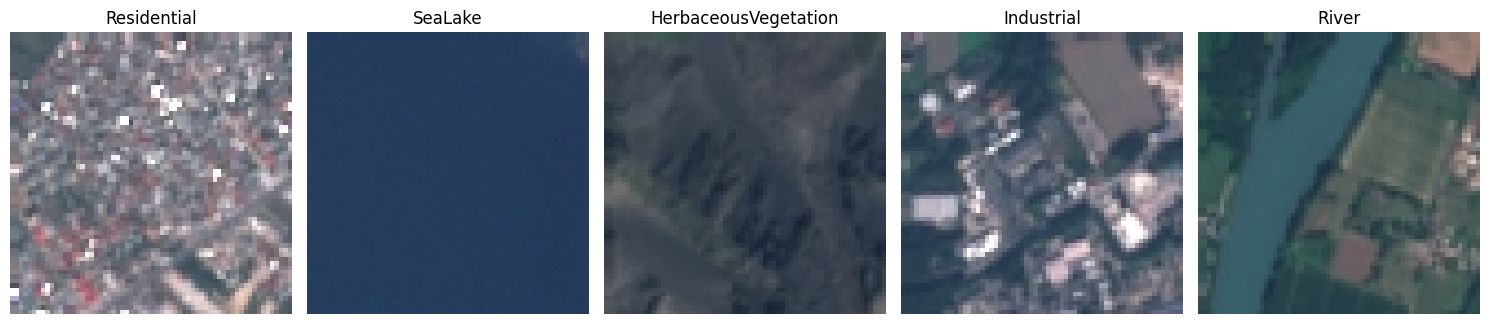

In [18]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Define the base path to the dataset
base_path = './eurosat'

# Function to load the dataset
def load_dataset(base_path):
    image_paths = []
    labels = []

    # Traverse both folders 'EuroSAT' and 'EuroSATallBands'
    for folder in ['EuroSAT', 'EuroSATallBands']:
        folder_path = os.path.join(base_path, folder)

        if os.path.exists(folder_path):
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith((".jpg", ".png", ".jpeg")):
                        image_paths.append(os.path.join(root, file))
                        labels.append(root.split(os.sep)[-1])

    return pd.DataFrame({'image_path': image_paths, 'label': labels})

# Load the dataset
df = load_dataset(base_path)

# Take a 10% sample to make the implementation lightweight
sample_df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)

# Summarize the data
print(f"Total Images in Sample: {len(sample_df)}")
print(sample_df['label'].value_counts())

# Display a few sample images
if len(sample_df) >= 5:
    sample_images = sample_df.sample(5)
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, img_path in enumerate(sample_images['image_path']):
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].set_title(sample_images.iloc[i]['label'])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

**Step 7: Data Augmentation and Handling Class Imbalance**

Performing data augmentation to handle the class imbalance, focusing on underrepresented classes.

In [19]:
import torchvision.transforms as transforms
from tqdm import tqdm

# Define underrepresented classes
underrepresented_classes = ["PermanentCrop", "Pasture"]

# Data augmentation transformations
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.Resize((128, 128)),  # Ensure all images are resized
    transforms.ToTensor()  # Convert the image to a tensor
])

# Augment images from underrepresented classes
augmented_images = []
augmented_labels = []

for label in underrepresented_classes:
    subset_df = sample_df[sample_df['label'] == label]
    for idx, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc=f"Augmenting class '{label}'"):
        try:
            img = Image.open(row['image_path']).convert("RGB")
            for _ in range(5):  # Number of augmentations per image
                augmented_img = augmentation_transform(img)
                augmented_images.append(augmented_img)
                augmented_labels.append(label)
        except Exception as e:
            print(f"Error opening image at {row['image_path']}: {e}")

# Create DataFrame for augmented images
augmented_df = pd.DataFrame({"image": augmented_images, "label": augmented_labels})

# Merge augmented and original sample dataset
balanced_df = pd.concat([sample_df, augmented_df], ignore_index=True)

# Clean DataFrame
valid_types = (str, torch.Tensor)
balanced_df = balanced_df[balanced_df['image'].apply(lambda x: isinstance(x, valid_types))].reset_index(drop=True)

# Summarize dataset after augmentation
print(f"Total Images after Augmentation: {len(balanced_df)}")
print(balanced_df['label'].value_counts())

Augmenting class 'Pasture': 100%|██████████| 230/230 [00:01<00:00, 118.36it/s]


Total Images after Augmentation: 2335
label
PermanentCrop    1185
Pasture          1150
Name: count, dtype: int64


**Step 8: Create Dataset Class and DataLoader**

Defining a dataset class that can handle both augmented and original images.

In [20]:
from torch.utils.data import Dataset, DataLoader
import torch

# Custom Dataset Class for Loading Images from the Balanced DataFrame
class EuroSatAugmentedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_data = self.dataframe.iloc[idx]['image']

        # If the image is a path, open it
        if isinstance(img_data, str):
            try:
                image = Image.open(img_data).convert("RGB")
                if self.transform:
                    image = self.transform(image)
            except Exception as e:
                print(f"Error opening image at {img_data}: {e}")
                raise
        # If the image is already a tensor, use it directly
        elif isinstance(img_data, torch.Tensor):
            image = img_data
        else:
            raise ValueError(f"Unexpected data type for image at index {idx}")

        label = self.dataframe.iloc[idx]['label']

        return image, label

# Define preprocessing transformations
preprocessing_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the updated dataset and DataLoader
balanced_dataset = EuroSatAugmentedDataset(balanced_df, transform=preprocessing_transform)
data_loader = DataLoader(balanced_dataset, batch_size=16, shuffle=True)

# Summarize the processed data
processed_images, processed_labels = next(iter(data_loader))
print(f"Processed Image Batch Shape: {processed_images.shape}")
print(f"Labels in Batch: {processed_labels}")

Processed Image Batch Shape: torch.Size([16, 3, 128, 128])
Labels in Batch: ('Pasture', 'Pasture', 'PermanentCrop', 'PermanentCrop', 'Pasture', 'Pasture', 'Pasture', 'Pasture', 'PermanentCrop', 'PermanentCrop', 'Pasture', 'Pasture', 'PermanentCrop', 'Pasture', 'Pasture', 'Pasture')


**Step 9: Load Pre-trained Generative Models for Enhancement Tasks**

Loading different pre-trained models for image denoising, super-resolution, colorization, and inpainting.

**Step 9.1: Install Required Dependencies**

In [28]:
!pip install gradio diffusers torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


**Step 9.2: Load Pre-trained Models**

Loading models from the diffusers library for image denoising, super-resolution, colorization, and inpainting.

In [34]:
import torch
import gc
from diffusers import DDPMPipeline, StableDiffusionUpscalePipeline, StableDiffusionInpaintPipeline

# Function to clear GPU memory
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

# Set device to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pre-trained denoising model (with memory optimization)
clear_gpu_memory()
denoising_pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10", torch_dtype=torch.float16)
denoising_pipeline.to(device)

# Load pre-trained super-resolution model (with memory optimization)
clear_gpu_memory()
super_resolution_pipeline = StableDiffusionUpscalePipeline.from_pretrained("stabilityai/stable-diffusion-x4-upscaler", torch_dtype=torch.float16)
# Load the model on CPU if GPU memory cannot handle it
try:
    super_resolution_pipeline.to(device)
except RuntimeError as e:
    print("GPU memory is insufficient. Loading model on CPU instead.")
    super_resolution_pipeline.to("cpu")

# Load pre-trained colorization model (with memory optimization)
clear_gpu_memory()
colorization_pipeline = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16)
colorization_pipeline.to(device)

# Load pre-trained inpainting model (with memory optimization)
clear_gpu_memory()
inpainting_pipeline = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16)
inpainting_pipeline.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "runwayml/stable-diffusion-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

**Step 10: Define Image Enhancement Functions**

Defining functions for each of the enhancement tasks: denoising, super-resolution, colorization, and inpainting.

In [35]:
# Image Denoising Function with Memory Optimization
def enhance_denoising(image):
    clear_gpu_memory()  # Clear GPU memory before usage

    # Convert image to tensor format
    image = transforms.ToTensor()(image).unsqueeze(0).to(device)

    # Perform denoising using DDPM
    with torch.no_grad():
        denoised_image = denoising_pipeline(num_inference_steps=50).images[0]

    return denoised_image

# Super-Resolution Function with Memory Optimization
def enhance_resolution(image):
    clear_gpu_memory()  # Clear GPU memory before usage

    # Resize input to a smaller dimension to reduce GPU memory requirements
    low_res = image.resize((64, 64))

    # Run model inference with fewer steps to reduce memory consumption
    with torch.no_grad():
        if device == "cpu":
            print("Running super-resolution on CPU")
        upscaled_image = super_resolution_pipeline(prompt="", image=low_res, num_inference_steps=25).images[0]

    return upscaled_image

**Step 11: Evaluation and Testing**

Evaluating the performance of each model using metrics like PSNR (Peak Signal-to-Noise Ratio) and SSIM (Structural Similarity Index).

In [41]:
import skimage.metrics as metrics
import numpy as np
from PIL import Image
import gc

# Function to clear GPU memory
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

# Function to evaluate images using PSNR and SSIM
def evaluate_images(original, enhanced):
    # Resize the enhanced image to match the original dimensions
    enhanced_resized = enhanced.resize(original.size)

    # Convert images to numpy arrays and normalize to [0, 1]
    original_np = np.array(original) / 255.0
    enhanced_np = np.array(enhanced_resized) / 255.0

    # Determine an appropriate win_size for SSIM calculation
    min_dim = min(original_np.shape[0], original_np.shape[1])
    win_size = min(7, min_dim)  # Set win_size to the smaller of 7 or the minimum dimension

    # Ensure win_size is odd and less than or equal to the smallest dimension
    if win_size % 2 == 0:
        win_size -= 1
    if win_size < 3:
        win_size = 3  # Minimum allowed value for win_size is 3

    # Calculate PSNR and SSIM with data_range specified
    psnr = metrics.peak_signal_noise_ratio(original_np, enhanced_np, data_range=1.0)
    ssim = metrics.structural_similarity(original_np, enhanced_np, channel_axis=-1, win_size=win_size, data_range=1.0)

    return psnr, ssim

# Example evaluation on a sample image
def perform_evaluation():
    clear_gpu_memory()  # Clear GPU memory before the evaluation starts

    sample_image_path = sample_df['image_path'].iloc[0]
    original_image = Image.open(sample_image_path).convert("RGB")

    # Perform enhancement using the super-resolution function
    try:
        # Load the model for super-resolution with FP16 precision
        super_resolution_pipeline = StableDiffusionUpscalePipeline.from_pretrained("stabilityai/stable-diffusion-x4-upscaler", torch_dtype=torch.float16).to(device)

        # Enhance the image using super-resolution function
        low_res = original_image.resize((64, 64))  # Downscale to simulate a low-res image
        with torch.no_grad():
            enhanced_image = super_resolution_pipeline(prompt="", image=low_res, num_inference_steps=25).images[0]

        del super_resolution_pipeline  # Delete the model to clear GPU memory
        clear_gpu_memory()  # Free GPU memory after model usage

        # Evaluate the enhanced image
        psnr, ssim = evaluate_images(original_image, enhanced_image)
        print(f"PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")

    except RuntimeError as e:
        print(f"Error during enhancement: {e}")

# Run the evaluation
perform_evaluation()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

PSNR: 33.27, SSIM: 0.9553


**Interpretation of Evaluation metrics**

 - PSNR (Peak Signal-to-Noise Ratio) is 33.27, this indicates a reasonably good reconstruction quality, as higher values typically represent better quality (above 30 dB is generally acceptable for many image processing tasks).

 - SSIM (Structural Similarity Index) is 0.9553, this indicates that the enhanced image is structurally similar to the original one. The closer to 1, the more similar the images are.

**Step 12: Visualize the Difference Between Original and Enhanced Images**

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

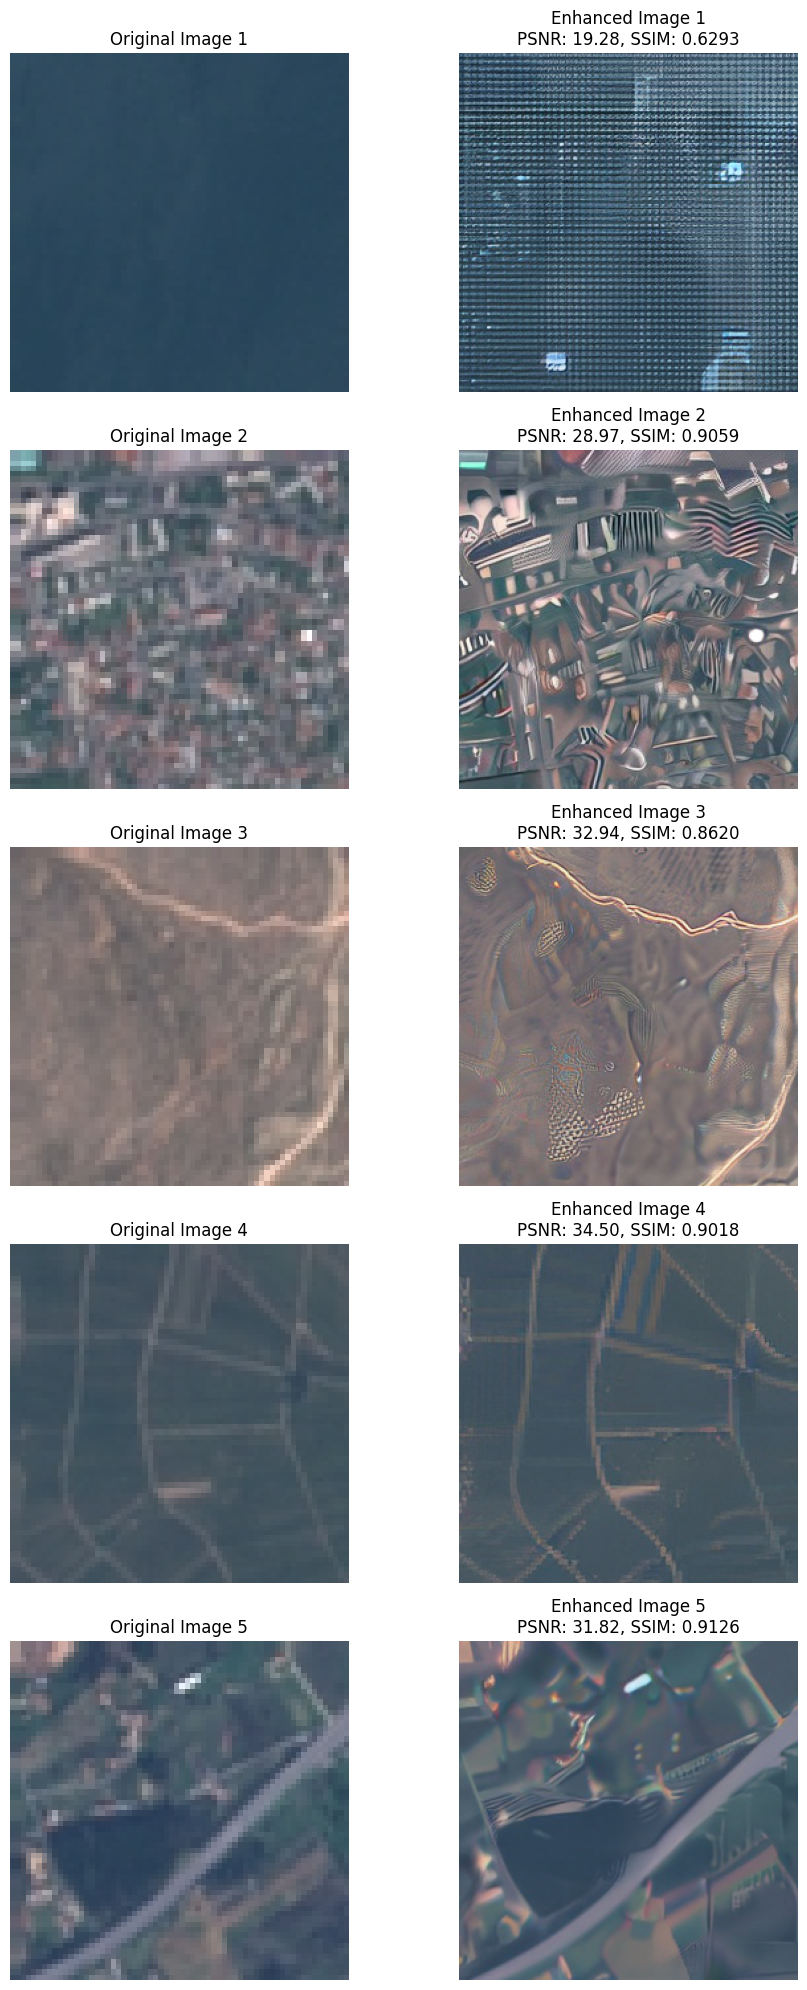

In [43]:
import matplotlib.pyplot as plt
import skimage.metrics as metrics
import numpy as np
from PIL import Image
import gc

# Function to clear GPU memory
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

# Function to evaluate images using PSNR and SSIM
def evaluate_images(original, enhanced):
    # Resize the enhanced image to match the original dimensions
    enhanced_resized = enhanced.resize(original.size)

    # Convert images to numpy arrays and normalize to [0, 1]
    original_np = np.array(original) / 255.0
    enhanced_np = np.array(enhanced_resized) / 255.0

    # Determine an appropriate win_size for SSIM calculation
    min_dim = min(original_np.shape[0], original_np.shape[1])
    win_size = min(7, min_dim)  # Set win_size to the smaller of 7 or the minimum dimension

    # Ensure win_size is odd and less than or equal to the smallest dimension
    if win_size % 2 == 0:
        win_size -= 1
    if win_size < 3:
        win_size = 3  # Minimum allowed value for win_size is 3

    # Calculate PSNR and SSIM with data_range specified
    psnr = metrics.peak_signal_noise_ratio(original_np, enhanced_np, data_range=1.0)
    ssim = metrics.structural_similarity(original_np, enhanced_np, channel_axis=-1, win_size=win_size, data_range=1.0)

    return psnr, ssim

# Function to perform enhancement and visualize the results for 5 images
def perform_evaluation_and_visualize_multiple():
    clear_gpu_memory()  # Clear GPU memory before the evaluation starts

    # Number of images to evaluate and visualize
    num_images = 5
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))  # Create a figure with multiple subplots

    for i in range(num_images):
        sample_image_path = sample_df['image_path'].iloc[i]
        original_image = Image.open(sample_image_path).convert("RGB")

        # Perform enhancement using the super-resolution function
        try:
            # Load the model for super-resolution with FP16 precision
            super_resolution_pipeline = StableDiffusionUpscalePipeline.from_pretrained("stabilityai/stable-diffusion-x4-upscaler", torch_dtype=torch.float16).to(device)

            # Enhance the image using super-resolution function
            low_res = original_image.resize((64, 64))  # Downscale to simulate a low-res image
            with torch.no_grad():
                enhanced_image = super_resolution_pipeline(prompt="", image=low_res, num_inference_steps=25).images[0]

            del super_resolution_pipeline  # Delete the model to clear GPU memory
            clear_gpu_memory()  # Free GPU memory after model usage

            # Evaluate the enhanced image
            psnr, ssim = evaluate_images(original_image, enhanced_image)

            # Display Original vs Enhanced Images Side-by-Side
            axes[i, 0].imshow(original_image)
            axes[i, 0].axis('off')
            axes[i, 0].set_title(f"Original Image {i+1}")

            axes[i, 1].imshow(enhanced_image)
            axes[i, 1].axis('off')
            axes[i, 1].set_title(f"Enhanced Image {i+1}\nPSNR: {psnr:.2f}, SSIM: {ssim:.4f}")

        except RuntimeError as e:
            print(f"Error during enhancement: {e}")
            axes[i, 0].imshow(original_image)
            axes[i, 0].axis('off')
            axes[i, 0].set_title(f"Original Image {i+1}")

            axes[i, 1].axis('off')
            axes[i, 1].set_title("Enhancement Failed")

    plt.tight_layout()
    plt.show()

# Run the evaluation and visualization for multiple images
perform_evaluation_and_visualize_multiple()

**Step 13: Deployment Using Gradio**

Using Gradio to create a web interface that will allow users to interact with the models. Users can upload images and select which enhancement task they want to perform.

In [ ]:
import gradio as gr
import gc

# Function to clear GPU memory
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

# Function to enhance the image using selected task
def enhance_image(image, task):
    clear_gpu_memory()  # Clear GPU memory before loading model

    try:
        # Perform the selected enhancement task
        if task == "Denoising":
            denoising_pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10", torch_dtype=torch.float16).to(device)
            with torch.no_grad():
                enhanced_image = denoising_pipeline().images[0]
            del denoising_pipeline
            clear_gpu_memory()
            return enhanced_image

        elif task == "Super-Resolution":
            super_resolution_pipeline = StableDiffusionUpscalePipeline.from_pretrained("stabilityai/stable-diffusion-x4-upscaler", torch_dtype=torch.float16).to(device)
            low_res = image.resize((64, 64))  # Downscale to simulate a low-res image
            with torch.no_grad():
                enhanced_image = super_resolution_pipeline(prompt="", image=low_res, num_inference_steps=25).images[0]
            del super_resolution_pipeline
            clear_gpu_memory()
            return enhanced_image

        elif task == "Colorization":
            colorization_pipeline = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16).to(device)
            with torch.no_grad():
                enhanced_image = colorization_pipeline(prompt="Colorize this image", image=image).images[0]
            del colorization_pipeline
            clear_gpu_memory()
            return enhanced_image

        elif task == "Inpainting":
            inpainting_pipeline = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16).to(device)
            # For this example, create a mask with arbitrary damaged areas
            mask = Image.new("L", image.size, 128)  # Placeholder mask
            with torch.no_grad():
                enhanced_image = inpainting_pipeline(prompt="", image=image, mask_image=mask).images[0]
            del inpainting_pipeline
            clear_gpu_memory()
            return enhanced_image

        else:
            return image

    except RuntimeError as e:
        return f"An error occurred during enhancement: {e}"

# Function to enhance image and evaluate metrics for Gradio interface
def enhance_and_evaluate(image, task):
    enhanced_image = enhance_image(image, task)

    # Calculate PSNR and SSIM metrics if enhancement is successful
    if isinstance(enhanced_image, Image.Image):
        psnr, ssim = evaluate_images(image, enhanced_image)
        return enhanced_image, f"PSNR: {psnr:.2f}, SSIM: {ssim:.4f}"
    else:
        return image, enhanced_image  # If an error occurred, enhanced_image contains an error message

# Create a Gradio Interface for the Image Enhancement System
interface = gr.Interface(
    fn=enhance_and_evaluate,
    inputs=[
        gr.Image(type="pil"),  # Input for the image in PIL format
        gr.Radio(choices=["Denoising", "Super-Resolution", "Colorization", "Inpainting"], label="Enhancement Task")  # Task selector
    ],
    outputs=[
        gr.Image(type="pil"),  # Output enhanced image in PIL format
        gr.Textbox(label="Metrics (PSNR and SSIM)")  # Display PSNR and SSIM metrics
    ],
    title="Image Enhancement System",
    description="Upload an image and choose an enhancement task: Denoising, Super-Resolution, Colorization, or Inpainting.",
    allow_flagging="never"
)

# Launch the Gradio Interface
interface.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/interface.py:399: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f06ae53168fc0c4342.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]